# Assignment 2 - Question 3
The objective of this assignment is to get you familiarize with  the  problem  of  `Dimensionality Reduction`.

## Instructions
- Write your code and analysis in the indicated cells.
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Do not attempt to change the contents of other cells.
- No inbuilt functions to be used until specified. Libraries allowed (Numpy, matplotlib)

## Datasets 
- The IIIT-CFW is database for the cartoon faces in the wild. The dataset contains 8928 annotated cartoon faces of famous personalities of the world with varying profession. Additional 1000 real faces of the public figure to study cross modal retrieval tasks, such as, Photo2Cartoon retrieval. Ref - https://cvit.iiit.ac.in/research/projects/cvit-projects/cartoonfaces
- We have sub sampled the following data for this assignment - Cartoon faces of 8 subjects and approx. 100 images for each subject. 

## Submission
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Rename the notebook to `<roll_number>_Assignment2_Q3.ipynb`.

In [2]:
# Installing Pillow Libraries
%pip install scikit-learn matplotlib Pillow

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import os
from random import randrange
from matplotlib import pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm

## Load Data

In [2]:
cfw_dict = {
    'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7
}

cfw_dict_rev = {
    0: 'Amitabhbachan',
    1: 'AamirKhan',
    2: 'DwayneJohnson',
    3: 'AishwaryaRai',
    4: 'BarackObama',
    5: 'NarendraModi',
    6: 'ManmohanSingh',
    7: 'VladimirPutin'
}

opt = {
    'image_size': 32,
    'is_grayscale': False,
    'val_split': 0.75
}

In [3]:
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

def display_images(imgs, classes, row=1, col=2, w=32, h=32):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

def load_data(dir_path):
    image_list = []
    y_list = []
    label_dict = cfw_dict
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue
    image_list = np.array(image_list)
    y_list = np.array(y_list)
    print("Dataset shape:",image_list.shape)
    print("Label shape:",y_list.shape)

    return image_list,y_list

In [4]:
dirpath = './IIIT-CFW/'
X,y = load_data(dirpath)

Dataset shape: (672, 32, 32, 3)
Label shape: (672,)


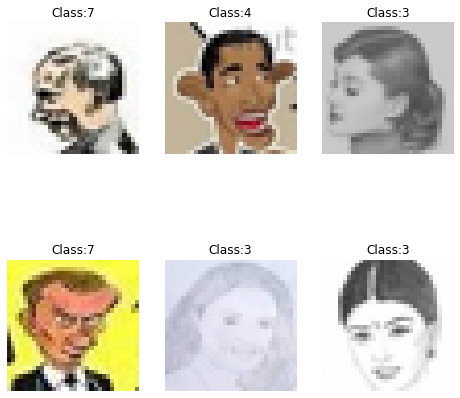

In [5]:
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]

ind = np.random.randint(0, y.shape[0], 6)
display_images(X[ind,...],y[ind], row=2, col=3)

## Dimensionality Reduction
- Plot eigen spectrum for the data.

Percentage of variance preserved is defined as the fraction of eigen values used. As we include more principal components to describe the data, the percentage of variances preserved under the dimensionality reduction increases. 

- Plot the percentage of variances vs the number of principal components to validate the above statement.
- Try visualizing these eigen vectors. Comment on what these ghost faces represent 
- Try reconstructing images with your choice of number of principal components and visualize the reconstructed image.

Let's define reconstruction error as the frobenius norm of the difference between original and reconstructed image. 

- Plot the number of principal components vs the corresponding reconstruction error for 5 selected number of principal components of your choice.
- Using the two dominant principal values, plot the data with colors showing the labels. What do you observe?


#### Write a function that gives eigen values and eigen vectors given data

In [6]:
def qr_algorithm(A, num_iters=50):
    def norm(A):
        return np.sqrt(A.T@A)

    def qr_decomposition(A):
        _A = A.copy()
        Q = np.zeros_like(_A)

        Q[:, 0] = A[:, 0] / norm(A[:, 0])
        for i in range(1, _A.shape[1]):
            for j in range(i):
                _A[:, i] -= Q[:, j] * np.dot(A[:, i].T, Q[:, j])
            Q[:, i] = _A[:, i] / norm(_A[:, i])

        return Q, Q.T @ A

    def qr_decomposition_faster(A):
        _A = A.copy()
        Q = np.zeros_like(_A)

        Q[:, 0] = A[:, 0] / norm(A[:, 0])
        for i in range(1, _A.shape[1]):
            _A[:, i] -= Q[:, :i] @ (Q[:, :i].T @ A[:, i])
            Q[:, i] = _A[:, i] / norm(_A[:, i])

        return Q, Q.T @ A

    Q = np.eye(A.shape[0])
    for _ in tqdm(range(num_iters)):
        _Q, R = qr_decomposition_faster(A)
        A = R @ _Q
        Q = Q @ _Q
    
    return A, Q

In [7]:
def eigen(mat, num_iters=25):
    A, Q = qr_algorithm(mat, num_iters=num_iters)
    eigenvalues = np.array([np.array(A)[i][i] for i in range(A.shape[0])])
    return eigenvalues, Q

#### Compute eigen values and plot eigen value spectrum

In [8]:
def cov_matrix(mat):
    mat -= np.mean(mat, axis=0)
    return (mat.T @ mat) / (mat.shape[0] - 1)

In [9]:
img_vecs = X.reshape(X.shape[0], -1)
img_vecs.shape

(672, 3072)

In [10]:
cov = cov_matrix(img_vecs)
cov.shape

(3072, 3072)

In [11]:
eigenval, eigenvec = np.linalg.eig(cov)
eigenval = np.real(eigenval)
eigenvec = np.real(eigenvec)

In [12]:
eigenval_sort_order = np.argsort(eigenval)[::-1]
eigenval[eigenval_sort_order][:5]

array([80.53217723, 19.98192874, 12.9505097 ,  7.10403262,  6.46406331])

In [13]:
def plot_eigen_spectrum(eigenvalues):
    eigenvals = eigenvalues
    plt.plot(range(1, len(eigenvals) + 1), np.sort(eigenvals)[::-1])
    plt.title('Eigen Spectrum')
    plt.ylabel('Eigen Values')
    plt.xlabel('Index')
    plt.xticks(range(1, len(eigenvals) + 1, 499))

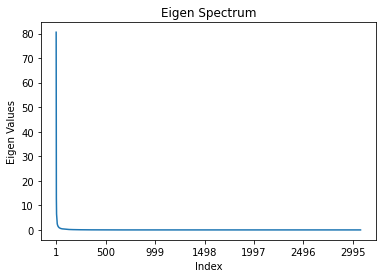

In [14]:
plot_eigen_spectrum(eigenval)

#### Plot the percentage of variances vs the number of principal components

In [15]:
def plot_var_pc(eigenval):
    total = sum(eigenval)
    x = range(1, len(eigenval) + 1)
    y = [(sum(eigenval[:i]) / total) * 100 for i in range(1, len(eigenval) + 1)]
    
    plt.plot(x, y)
    plt.title('Percentage of Variances Vs No. of Principal Components')
    plt.ylabel('% of Variance')
    plt.xlabel('No. of Principal Components')
    plt.xticks(range(1, len(eigenval) + 1, 499))
    plt.yticks(range(0, 101, 10))

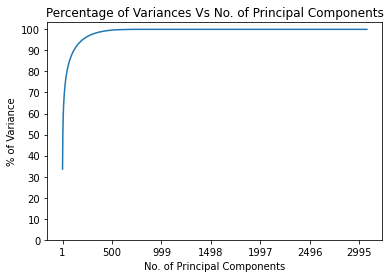

In [16]:
plot_var_pc(eigenval)

#### Visualize eigen faces(eigen vectors)

In [17]:
def plot(image, H, W, C, indices):
    pl = np.reshape(image.T,(-1, H, W, C))
    plt.figure(figsize=(25,25))
    for c,i in enumerate(indices):
        ele = pl[i]
        minim = np.min(ele)
        maxim = np.max(ele)
        ele = (ele - minim) / (maxim - minim)
        ele = np.clip(ele,0,254)
        plt.subplot(1,12,c+1)
        plt.axis('off')
        plt.imshow(ele)
    plt.show()

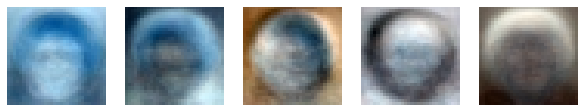

In [109]:
indices = [randrange(12) + 1 for _ in range(5)]
plot(np.real(eigenvec), H, W, C, indices)

The eigen faces represent the set of basic images that can linearly combined to reconstruct dataset images (to be precise they are the principal components of the images). The corresponding eigenvalue of these eigenfaces will tell about how much contribution the corresponding eigenface (or eigenvector) has in dataset images. 
For reconstruction, we could use the eigenvectors (or preferably a subset of them), to transform the image into a combination of eigenfaces.

#### Reconstruction 

In [133]:
def reconstruct(vec, eigenvec, k):
    eigenvecs = eigenvec[:, :k]
    return vec @ eigenvecs @ eigenvecs.T

Example of 50-component-reconstruction


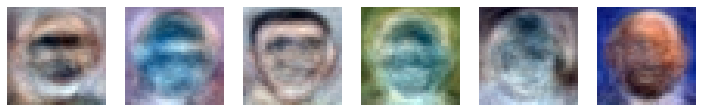

Example of 200-component-reconstruction


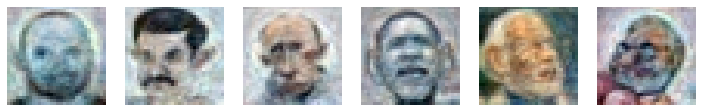

Example of 500-component-reconstruction


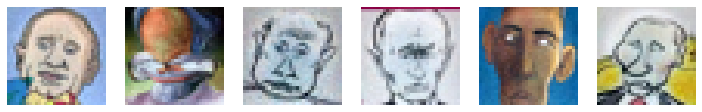

Example of 1000-component-reconstruction


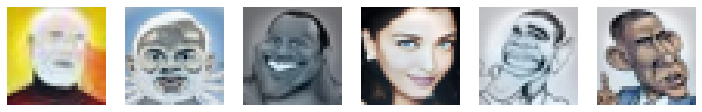

Example of 1500-component-reconstruction


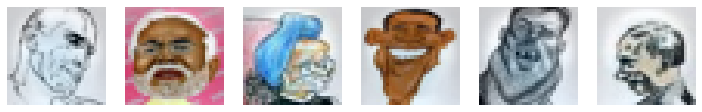

In [207]:
num_components = [50, 200, 500, 1000, 1500]
f_errors = []

for component in num_components:
    res = reconstruct(img_vecs, eigenvec, component)
    print(f"Example of {component}-component-reconstruction")
    f_errors.append(np.linalg.norm(res - img_vecs))
    indices = [randrange(0, res.shape[0], 1) for i in range(6)]
    plot(res.T, H, W, C, indices)

Text(0, 0.5, 'Frobenius norm')

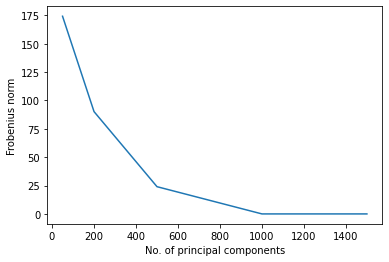

In [136]:
plt.plot(num_components, f_errors)
plt.xlabel('No. of principal components')
plt.ylabel('Frobenius norm')

#### Plot data in 2D

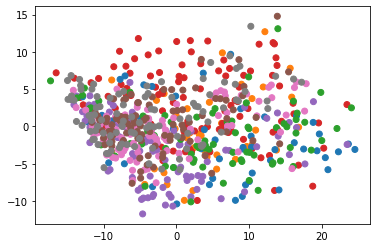

In [204]:
eigenvecs = eigenvec[:, :2]
res = img_vecs @ eigenvecs
cmap = np.array(sns.color_palette(palette='tab10', n_colors=len(cfw_dict.keys())))
plt.scatter(res[:, 0], res[:, 1], c=cmap[y])

For a data that originally has $3072$ dimensions, if we were to reduce all that information into just $2$ dimensions, that would not be sufficient enough to represent the information that was in the image, leading to a huge loss in information (*can be seen in the scatter plot as well as from the frobenius norm plot*). At the same time increasing the number of components after a certain won't help much, as we can see from the frobenius norm plot, which tends to faltten out after 1500 principal components.

## Lets analyze the principal components classwise
- Visualize dominant eigen faces of each of the classes.
- Print the number of principal components required to retain 90% variance for each of the classes and for the entire dataset
- Are the number of components same for entire dataset and each of the classes. If yes why? If not why?

Example output:
```
Number of principal components required for 90% reconstruction of the:
Entire Dataset = 10 
Amitabhbachan = 10
AamirKhan = 10
...
```

In [13]:
X,y = load_data(dirpath)

Dataset shape: (672, 32, 32, 3)
Label shape: (672,)


In [163]:
class_wise_data = {i: [] for i in range(8)}
for x, label in zip(X, y):
    class_wise_data[label].append(x)

class_wise_eig = {}
for key in class_wise_data:
    vec = np.array(class_wise_data[key])
    eigenval, eigenvec = np.linalg.eig(cov_matrix(vec.reshape(vec.shape[0], -1)))
    class_wise_eig[key] = {'eigenval': eigenval, 'eigenvec': eigenvec}

#### Visualize dominant eigen faces of each of the classes

0: Amitabhbachan


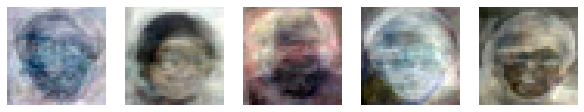

1: AamirKhan


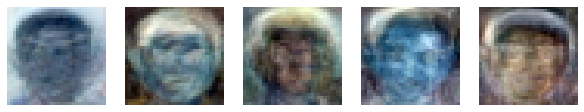

2: DwayneJohnson


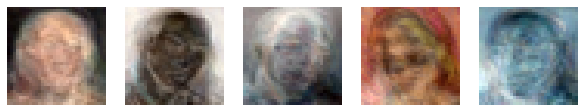

3: AishwaryaRai


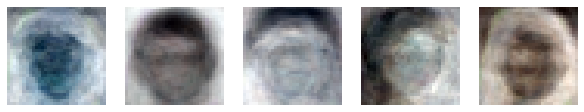

4: BarackObama


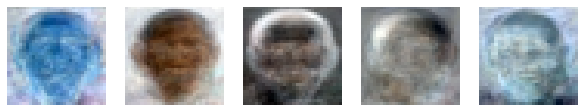

5: NarendraModi


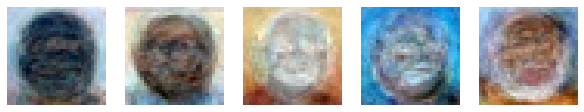

6: ManmohanSingh


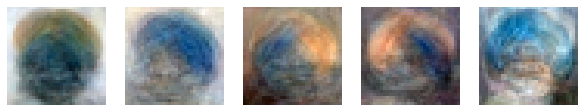

7: VladimirPutin


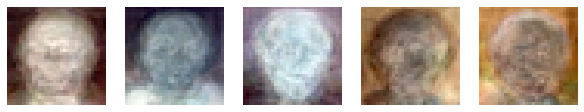

In [164]:
for key in class_wise_eig:
    sort_order = np.argsort(class_wise_eig[key]['eigenval'])[::-1]
    print(f"{key}: {cfw_dict_rev[key]}")
    plot(np.real(class_wise_eig[key]['eigenvec']), H, W, C, sort_order[:5])

#### Number of principal components required to retain 90% variance for each of the classes and for the entire dataset

In [176]:
eigenval_sum = np.sum(eigenval)
s = 0
for i in range(len(eigenval_sort_order)):
    s += eigenval[eigenval_sort_order[i]]
    if s >= 0.9 * eigenval_sum:
        print(f"0. Dataset - {i + 1}")
        break

for key in class_wise_eig:
    sort_order = np.argsort(class_wise_eig[key]['eigenval'])[::-1]
    eigenval_sum = np.sum(class_wise_eig[key]['eigenval'])
    s = 0
    for i in range(len(sort_order)):
        s += class_wise_eig[key]['eigenval'][sort_order[i]]
        if s >= 0.9 * eigenval_sum:
            print(f"{key + 1}. {cfw_dict_rev[key]} - {i + 1}")
            break

0. Dataset - 115
1. Amitabhbachan - 21
2. AamirKhan - 24
3. DwayneJohnson - 28
4. AishwaryaRai - 36
5. BarackObama - 43
6. NarendraModi - 57
7. ManmohanSingh - 50
8. VladimirPutin - 44


#### Analysis : Are the number of components same for entire dataset and each of the classes. If yes why? If not why?

The number of components are not the same for the entire dataset or each of the classes. It was never supposed to be same since all the different classes have different internal features (or different patterns) the their corresponding eigenvector needs to capture so as to effictively represent them. The different internal features arise mainly due to the difference in color of pixels with repect to their vector space, leading to a different set of eigenvectors and number of components.

## Linear Regression (continued)
1. Perform linear regression on below datapoints
2. Use PCA for dimensionality reduction on this datapoints and then perform Linear regression.
3. Perform this experiment on different number of components and report the score for linear regression. Plot the graph of [1-200] principal components vs regression score. What do you observe?

Note :- Can use inbuilt functions for Linear Regression and PCA for this question

In [178]:
# datapoints
X,_ = load_data(dirpath)
X = X.reshape((X.shape[0],-1))
label = np.array([randrange((32*32*3)) for i in range(5)])
label = np.mean(X[:,label], axis = 1)
print(label.shape)

Dataset shape: (672, 32, 32, 3)
Label shape: (672,)
(672,)


In [182]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
from tqdm import tqdm

X_train, X_test, y_train, y_test = train_test_split(X, label)
mse_scores = []

In [183]:
for n_components in tqdm(range(1, 200)):
    pca = PCA(n_components=n_components)
    x_train = pca.fit_transform(X_train)
    x_test = pca.transform(X_test)

    model = LinearRegression().fit(x_train, y_train)
    y_pred = model.predict(x_test)
    
    mse_scores.append(mean_squared_error(y_test, y_pred))

100%|██████████| 199/199 [00:17<00:00, 11.44it/s]


Text(0, 0.5, 'MSE Score')

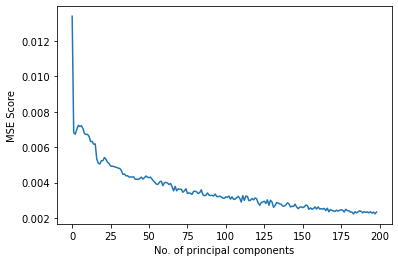

In [184]:
plt.plot(mse_scores)
plt.xlabel('No. of principal components')
plt.ylabel('MSE Score')

Increasing the number of principal components does help in improving the mse scores to a certain extent, but after a certain threshold (~200 in this case) it will saturate and adding further principal components would not improve the performance in any significant way, since most information is already captured by the more influential components (higher eigenvalues).